In [ ]:
# Checkout www.pygimli.org for more examples


# Geostatistical regularization

In this example we illustrate the use of geostatistical constraints on
irregular meshes as presented by :cite:`jordi2018geostatistical`, compared to
classical smoothness operators of first or second kind.

The elements of the covariance matrix $\textbf{C}_{\text{M}}$ are defined
by the distances H between the model cells i and j into the three directions

\begin{align}\textbf{C}_{\text{M},ij}=\sigma^{2}\exp{\left(
        -3\sqrt{\left(\frac{\textbf{H}^x_{ij}}{I_{x}}\right)^{2}+
                \left(\frac{\textbf{H}^y_{ij}}{I_{y}}\right)^{2}+
                \left(\frac{\textbf{H}^z_{ij}}{I_{z}}\right)^{2}}\right)}.\end{align}

It defines the correlation between model cells as a function of correlation
lenghts (ranges) $I_x$, $I_y$, and $I_z$. Of course, the
orientation of the coordinate axes is arbitrary and can be chosen by rotation.
Let us illustrate this by a simple mesh:


## Computing covariance and constraint matrices
We create a simple mesh using a box geometry



(<Axes: >, <matplotlib.colorbar.Colorbar at 0x1e0b3d24ee0>)

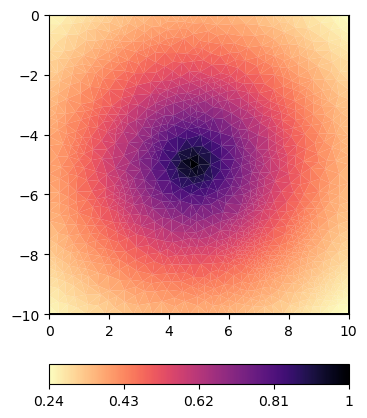

In [2]:
import matplotlib.pyplot as plt
from matplotlib.patches import CirclePolygon
from matplotlib.collections import PatchCollection
from matplotlib.colors import LogNorm
import numpy as np
import pygimli as pg
import pygimli.meshtools as mt
from pygimli.frameworks import PriorModelling

# We create a rectangular domain and mesh it with small triangles
rect = mt.createRectangle(start=[0, -10], end=[10, 0])
mesh = mt.createMesh(rect, quality=34.5, area=0.1)

# We compute such a covariance matrix by calling
CM = pg.utils.covarianceMatrix(mesh, I=5)  # I taken for both x and y
# We search for the cell where the midpoint (5, -5) is located in
ind = mesh.findCell([5, -5]).id()
# and plot the according column using index access (numpy)
pg.show(mesh, CM[:, ind], cMap="magma_r")
# ax.plot(pg.x(pos), pg.y(pos), "kx")

According to inverse theory, we use the square root of the covariance matrix
as single-side regularization matrix C. It is computed by using an eigenvalue
decomposition

\begin{align}\textbf{C}_\text{M} = \textbf{Q}\textbf{D}\textbf{Q}^{T}\end{align}

based on LAPACK (numpy.linalg). The inverse square root is defined by

\begin{align}\textbf{C}_\text{M}^{-0.5} = \textbf{Q}\textbf{D}^{-0.5}\textbf{Q}^{T}\end{align}

In order to avoid a matrix inverse (square root), a special matrix is derived
doing the decomposition and storing the eigenvectors and eigenvalues values.
A multiplication is done by multiplying with Q and scaling with the diagonal.
This matrix is implemented in the matrix module
by the class :py:mod:`pg.matrix.Cm05Matrix`



In [3]:
Cm05 = pg.matrix.Cm05Matrix(CM)

However, this matrix does not return a zero vector for a constant vector



In [4]:
out = Cm05 * pg.Vector(mesh.cellCount(), 1.0)
print("min/max value ", min(out), max(out))

min/max value  0.021592434321541704 0.20503355104238002


as desired for a roughness operator. Therefore, an additional matrix called
:py:mod:`pg.matrix.GeostatisticalConstraintsMatrix`
was implemented where this spur is corrected for.
It is, like the correlation matrix, created by a mesh, a list of correlation
lengths I, a dip angle that distorts the x/y plane and a strike angle
towards the third direction.




In [5]:
C = pg.matrix.GeostatisticConstraintsMatrix(mesh=mesh, I=5)

18/04/24 - 11:58:16 - pyGIMLi - INFO - (C) Time for eigenvalue decomposition 4.1s
18/04/24 - 11:58:16 - pyGIMLi - INFO - Cache stored: C:\Users\matthew.noteboom\AppData\Roaming\pygimli\Cache\6703972675426126887


In order to extract a column, we generate a vector with a single 1, multiply



In [6]:
vec = pg.Vector(mesh.cellCount())
vec[ind] = 1.0
cor = C * vec

and plot it using a linear or logarithmic scale



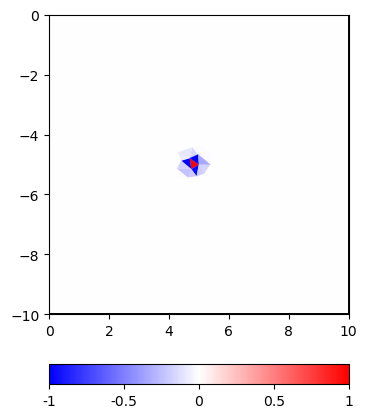

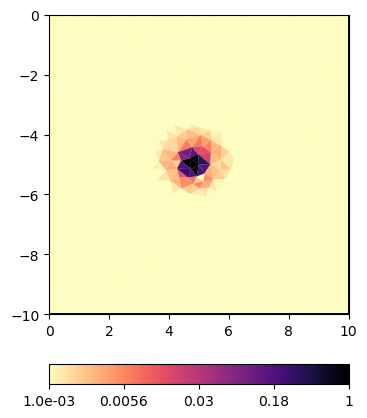

In [7]:
kwLin = dict(cMin=-1, cMax=1, cMap="bwr")
ax, cb = pg.show(mesh, cor, **kwLin)
kwLog = dict(cMin=1e-3, cMax=1, cMap="magma_r", logScale=True)
ax, cb = pg.show(mesh, pg.abs(cor), **kwLog)

The constraints have a rather small footprint compared to the correlation
if one considers values below a certain threshold as insignificant.



Such a matrix can also be defined for different ranges and dip angles, e.g.



18/04/24 - 12:01:08 - pyGIMLi - INFO - (C) Time for eigenvalue decomposition 4.0s
18/04/24 - 12:01:08 - pyGIMLi - INFO - Cache stored: C:\Users\matthew.noteboom\AppData\Roaming\pygimli\Cache\8709426827179915285


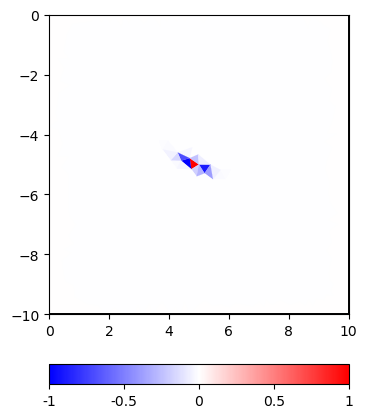

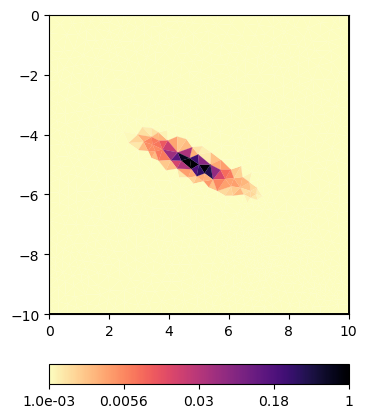

In [8]:
Cdip = pg.matrix.GeostatisticConstraintsMatrix(mesh=mesh, I=[9, 2], dip=-25)
ax, cb = pg.show(mesh, Cdip * vec, **kwLin)
ax, cb = pg.show(mesh, pg.abs(Cdip * vec), **kwLog)

Even in the linear scale, but more in the log scale one can see the
regularization footprint in the shape of an ellipsis.



In order to illustrate the role of the constraints, we use a very simple
mapping forward operator that retrieves the values in the mesh at some given
positions. The constraints are therefore used as interpolation operators.
Note that the mapping forward operator can also be used for defining prior
knowledge if combined with another forward operator in a classical joint
inversion framework.
In the initialization, the indices are stored and a mapping matrix is created
that projects the model vector to the forward response.
This matrix is also the Jacobian matrix for the inversion.



## Inversion with geostatistical constraints
We choose some positions and initialize the forward operator



18/04/24 - 12:06:26 - pyGIMLi - INFO - Found 1 regions.




Ctype=1: 31.5 51.5 276.8 100.5 195.7 0.8 


Ctype=2: 30.0 49.7 298.9 100.5 198.9 0.0 


Cg-5/5m: 30.0 47.7 290.4 96.2 193.1 0.5 


Cg-9/2m: 30.0 47.7 290.4 96.2 193.1 0.5 


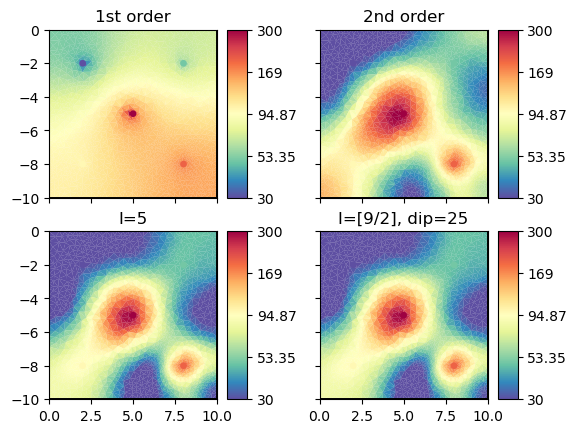

In [9]:
pos = [[2, -2], [8, -2], [5, -5], [2, -8], [8, -8]]
fop = PriorModelling(mesh, pos)
# For plotting the results, we create a figure and define some plotting options
fig, ax = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True)
kw = dict(
    colorBar=True,
    cMin=30,
    cMax=300,
    orientation='vertical',
    cMap='Spectral_r',
    logScale=True)

# We want to use a homogenenous starting model
vals = np.array([30, 50, 300, 100, 200])
# We assume a 5% relative accuracy of the values
relError = 0.05
# set up data and model transformation log-scaled
tLog = pg.trans.TransLog()
inv = pg.Inversion(fop=fop)
inv.transData = tLog
inv.transModel = tLog
inv.startModel = 30  # for all

# Initially, we use the first-order constraints (default)
# inv.setRegularization(cType=2)
res = inv.run(vals, relativeError=relError, cType=1, lam=30)
print(('Ctype=1: ' + '{:.1f} ' * 6).format(*fop(res), inv.chi2()))
pg.show(mesh, res, ax=ax[0, 0], **kw)
ax[0, 0].set_title("1st order")
np.testing.assert_array_less(inv.chi2(), 1.2)

# Next, we use the second order (curvature) constraint type
res = inv.run(vals, relativeError=relError, cType=2, lam=25)
print(('Ctype=2: ' + '{:.1f} ' * 6).format(*fop(res), inv.chi2()))
pg.show(mesh, res, ax=ax[0, 1], **kw)
ax[0, 1].set_title("2nd order")
np.testing.assert_array_less(inv.chi2(), 1.2)

# Now we set the geostatistic isotropic operator with 5m correlation length
res = inv.run(vals, relativeError=relError, lam=15, C=C)
print(('Cg-5/5m: ' + '{:.1f} ' * 6).format(*fop(res), inv.chi2()))
pg.show(mesh, res, ax=ax[1, 0], **kw)
ax[1, 0].set_title("I=5")
np.testing.assert_array_less(inv.chi2(), 1.2)

# and finally we use the dipping constraint matrix
res = inv.run(vals, relativeError=relError, lam=15, C=Cdip)
print(('Cg-9/2m: ' + '{:.1f} ' * 6).format(*fop(res), inv.chi2()))
pg.show(mesh, res, ax=ax[1, 1], **kw)
ax[1, 1].set_title("I=[9/2], dip=25")
np.testing.assert_array_less(inv.chi2(), 1.2)

# plot the position of the priors
patches = [CirclePolygon(po, 0.2) for po in pos]
for ai in ax.flat:
    p = PatchCollection(patches, cmap=kw['cMap'])
    p.set_facecolor(None)
    p.set_array(np.array(vals))
    p.set_norm(LogNorm(kw['cMin'], kw['cMax']))
    ai.add_collection(p)

Note that all four regularization operators fit the data equivalently but
the images (i.e. how the gaps between the data points are filled) are quite
different. This is something we should have in mind using regularization.



## Generating geostatistical media
For generating geostatistical media, one can use the function
generateGeostatisticalModel. It computes a correlation matrix and multiplies
it with a pseudo-random (randn) series. The arguments are the same as for the
correlation or constraint matrices.



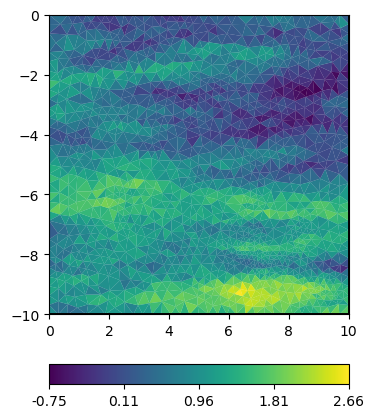

In [11]:
model = pg.utils.generateGeostatisticalModel(mesh, I=[20, 4])
ax, cb = pg.show(mesh, model)